In [2]:
import numpy as np
import cupy as cp
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras

In [3]:
# ========= 디바이스 확인 ==========
tf.python.client.device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7015791908047438686,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11609620859935993361
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2415205077789134400
 physical_device_desc: "device: XLA_GPU device"]

In [10]:
# ========== 데이터 샘플링 함수 정의 ===========

class make_dataset():
    def __init__(self, max_x, **kwargs):
        self.max_x = max_x
    def __call__(self):
        rep = self.max_x / 3
        c = 1 / rep / 6
        data = cp.array([])
        for i in range(int(rep)):
            data = cp.concatenate([data, cp.random.uniform(3*i, 3*i+1, [round(10000*c),])])
            data = cp.concatenate([data, cp.random.uniform(3*i+1, 3*i+2, [round(10000*2*c),])])
            data = cp.concatenate([data, cp.random.uniform(3*i+2, 3*(i+1), [round(10000*3*c),])])
        return data.astype('float32').get()

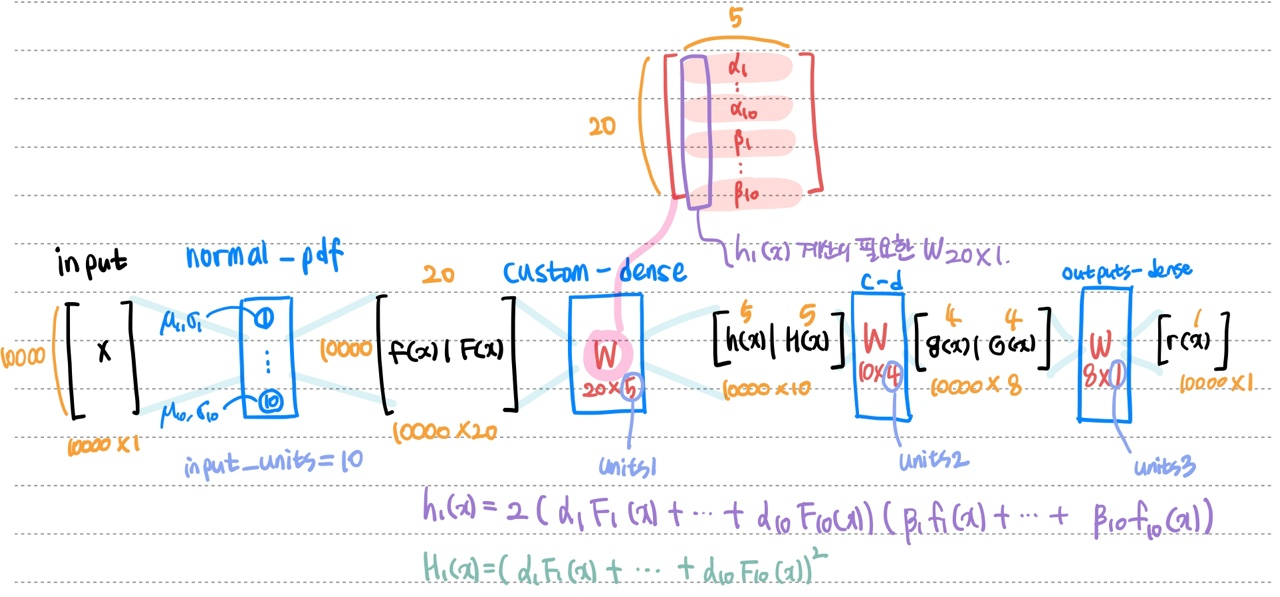

In [5]:
Image.open('model_structure.jpg')

In [91]:
from scipy.stats import norm
from tensorflow.keras import backend as K

# ========== Normal pdf, cdf layer 정의 ===========

class normal_dist(keras.layers.Layer):
    def __init__(self, units, max_x, **kwargs):
        super(normal_dist, self).__init__(**kwargs)
        self.units = units
        self.max_x = max_x
    
    def build(self, input_shape):
        self.shape = input_shape
        self.m_initializer = keras.initializers.RandomUniform(minval=3., maxval=4.)
        self.s_initializer = keras.initializers.RandomUniform(minval=0., maxval=2.)
        self._m = self.add_weight(name='mu', shape=(self.units,), initializer=self.m_initializer, trainable=True) # mu
        self._s = self.add_weight(name='sigma', shape=(self.units,), initializer=self.s_initializer, trainable=True) # sigma
    
    def call(self, x):
        ans = np.zeros((self.shape[-1], int(self.units*2)))
        for i in range(self.units):
            ans[:,i] = norm.pdf(x, self._m[i], self._s[i]) # tf fn로 바꾸기
            ans[:,i+10] = norm.cdf(x, self._m[i], self._s[i]) # tf fn로 바꾸기
        ans = ans.astype('float32')
        return tf.Variable(ans) # [f | F]
    
    def get_est(self):
        return K.concatenate([self._m, self._s], axis=1)

    
# ========== Activation layer 정의 ===========

class custom_dense(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(custom_dense, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.shape = input_shape
        self._w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        
    def call(self, x):
        therashold = int(self.shape[-1]/2)
        small = 2 * tf.matmul(x[:,therashold:], self._w[:therashold,:]) * tf.matmul(x[:,:therashold],self._w[therashold:,:]) 
        large = tf.square(tf.matmul(x[:,therashold:], self._w[:therashold,:]))
        return K.concatenate([small, large], axis=1)
    
class output_dense(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(output_dense, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.shape = input_shape
        self._w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        
    def call(self, x):
        therashold = int(self.shape[-1]/2)
        small = 2 * tf.matmul(x[:,therashold:], self._w[:therashold,:]) * tf.matmul(x[:,:therashold],self._w[therashold:,:]) 
        return small

    
# ========== Maximum Likelihood 목적 함수 정의 ===========
class MLE(keras.losses.Loss):
    def call(self, y_pred, y_true): # y_true는 사용안할 것
        return -K.log(y_pred) # 미분 가능하게

    
# ========== Model 함수 정의 ===========
class model(keras.layers.Layer):
    def __init__(self, max_x, input_units, units1, units2, units3, **kwargs):
        super(model, self).__init__(**kwargs)
        self.max_x = max_x
        self.input_units = input_units
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3
        
        self.inputs = normal_dist(self.input_units, self.max_x)
        self.layer1 = custom_dense(self.units1)
        self.layer2 = custom_dense(self.units2)
        self.outputs = output_dense(self.units3)
        
    def call(self, x):
        y = self.inputs(x)
        y = self.layer1(y)
        y = self.layer2(y)
        y = self.outputs(y)
        return y

In [93]:
data = make_dataset(6)()

input_layer = normal_dist(max_x=6, units=10)
layer1 = custom_dense(5)
layer2 = custom_dense(4)
layer3 = output_dense(1)

x = input_layer(data)
x = layer1(x)
x = layer2(x)
x = layer3(x)

x

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-1.0945374e-27],
       [ 1.3798232e-29],
       [-9.2242130e-27],
       ...,
       [ 3.6924247e-16],
       [ 6.0782338e-16],
       [ 3.4559111e-16]], dtype=float32)>

In [92]:
def training_step(x):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)
        predicted = model(x)
        # 손실 계산
        fake_data = np.ones((x.shape[0],1))
        loss = loss_fn(x, predicted)
    # 가중치 업데이트
    grads = tape.gradient(loss, model.trainable_weights)
    print(grads)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

batch_size = 128
data = make_dataset(6)()
fake_y = np.ones((10000,1))
fake_y = fake_y.astype('float32')
dataset = tf.data.Dataset.from_tensor_slices(np.concatenate([fake_y, data.reshape(-1,1)], axis=1)) # label 없을 때 생기는 오류 방지
dataset = dataset.batch(batch_size)

model = model(max_x=6, input_units=10, units1=5, units2=4, units3=1)
loss_fn = MLE()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

epochs = 10
losses = []

for step, x in enumerate(dataset):
    loss = training_step(x[:,1])
    losses.append(float(loss))

[None, None, None, None, None]


ValueError: No gradients provided for any variable: ['model_20/normal_dist_22/mu:0', 'model_20/normal_dist_22/sigma:0', 'model_20/custom_dense_40/Variable:0', 'model_20/custom_dense_41/Variable:0', 'model_20/output_dense_20/Variable:0'].